# Neural Network Pruning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/willsq/pruning/blob/master/notebooks/pruning.ipynb)


An exploration of neural network pruning strategies on a toy MNIST setup. We will investigate two strategies and their impact on final network sparsity, inference runtime and test accuracy. The focus here is on a clear presentation of the behaviour of these strategies.

References:
* https://jacobgil.github.io/deeplearning/pruning-deep-learning
* [To prune, or not to prune: exploring the efficacy of pruning for model compression](https://arxiv.org/abs/1710.01878)
* [Targeted Dropout](https://openreview.net/pdf?id=HkghWScuoQ)



## System setup

In [1]:
!pip3 install -q \
  tensorflow-gpu==2.0.0-beta1 \
  watermark \
  tqdm

     |████████████████████████████████| 348.9MB 32kB/s 
     |████████████████████████████████| 501kB 45.2MB/s 
     |████████████████████████████████| 3.1MB 41.3MB/s 


In [2]:
import tensorflow as tf
from functools import partial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import tqdm

tf.random.set_seed(42)

matplotlib.rc('figure', figsize=[10,5])
%load_ext watermark
%watermark -v -m -p tensorflow,numpy -g
!nvidia-smi

CPython 3.6.8
IPython 5.5.0

tensorflow 2.0.0-beta1
numpy 1.16.4

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.14.79+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :
Tue Jul  2 14:31:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+--------

## Model

### Definition

In [3]:
# reusable components for when we construct pruned models on the fly later
flatten = partial(tf.keras.layers.Flatten, input_shape=(28, 28))
dense = partial(tf.keras.layers.Dense, activation='relu', use_bias=False)
dense_to_softmax = partial(tf.keras.layers.Dense, 10, activation='softmax', use_bias=False)

model = tf.keras.models.Sequential([
  flatten(),
  dense(1000, name="prunable_1"),
  dense(1000, name="prunable_2"),
  dense(500, name="prunable_3"),
  dense(200, name="prunable_4"),
  dense_to_softmax(name="softmax"),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
prunable_1 (Dense)           (None, 1000)              784000    
_________________________________________________________________
prunable_2 (Dense)           (None, 1000)              1000000   
_________________________________________________________________
prunable_3 (Dense)           (None, 500)               500000    
_________________________________________________________________
prunable_4 (Dense)           (None, 200)               100000    
_________________________________________________________________
softmax (Dense)              (None, 10)                2000      
Total params: 2,386,000
Trainable params: 2,386,000
Non-trainable params: 0
______________________________________________

### Load MNIST

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

11493376/11490434 [==============================] - 0s 0us/step


### Train and evaluate

In [5]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

W0702 14:31:54.055631 139759274997632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.2113 - accuracy: 0.9372
Epoch 2/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1042 - accuracy: 0.9703
Epoch 3/5
60000/60000 [==============================] - 5s 89us/sample - loss: 0.0751 - accuracy: 0.9792
Epoch 4/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0615 - accuracy: 0.9826
Epoch 5/5
10000/10000 [==============================] - 1s 50us/sample - loss: 0.1084 - accuracy: 0.9791


[0.10836204209262106, 0.9791]

## Pruning methods

### Weight pruning

We define weight pruning here where we zero the smallest k% individual weights in each layer's weight matrix. Note this isn't global ranking of the model's weights but is performed layer-wise.

> To achieve 'sparsity' of $k$% we rank the individual weights in weight matrix $W$ according to their magnitude $|w_{i,j}|$, and then set to zero the smallest $k$%.

The application below is **in-place** instead of returning a mask.


In [0]:
def weight_prune(model, k):
  prunable_layers = [l for l in model.layers if "prunable" in l.name]
  
  for layer in prunable_layers:
    assert len(layer.get_weights()) == 1, "only supported with one dense matrix"

    weights = layer.get_weights()[0]
    abs_weights = np.abs(weights)
    threshold = np.percentile(abs_weights, k)
    mask = abs_weights < threshold
    weights[mask] = 0
    layer.set_weights([weights])
  
  return model

Now, construct a Keras model class to take the output of a weight-pruned model as above, but **replace the matmuls with sparse-matmuls** via the tensorflow tf.sparse API

In [0]:
# Class to take a pruned model and use the functional API to build a mirrored
# model but with sparse matmuls switched in 
class SparseWeightPruned(tf.keras.Model):

    def __init__(self, pruned_model):
        super().__init__()
        
        self.flatten = tf.keras.layers.Flatten()
        self.sparse_weights = []
        self.softmax_weights = None
        
        for layer in pruned_model.layers:
          if "prunable" in layer.name:
            st = self.dense_to_sparse(layer.get_weights()[0])
            self.sparse_weights.append(st)
          elif "softmax" in layer.name:  
            self.softmax_weights = layer.get_weights()[0]

    def call(self, x):
        x = self.flatten(x)
        x = tf.transpose(x)
        for st in self.sparse_weights:
          x = tf.sparse.sparse_dense_matmul(st, x, adjoint_a=True)
          x = tf.nn.relu(x)
        x = tf.transpose(x)
      
        x = tf.matmul(x, self.softmax_weights)
        return tf.nn.softmax(x)

    @staticmethod
    def dense_to_sparse(tensor):
      indices = tf.where(tf.not_equal(tensor, 0))
      values = tf.gather_nd(tensor, indices)
      shape = tf.shape(tensor, out_type=tf.int64)
      st = tf.sparse.SparseTensor(indices, values, dense_shape=shape)
      return tf.sparse.reorder(st)

# function to go straight from a fully-dense model to a weight-pruned model
# that uses sparse-matmuls
def weight_prune_sparse(model, k):
  model_pruned = weight_prune(model, k)
  model_pruned_sparse = SparseWeightPruned(model_pruned)

  model_pruned_sparse.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])
  return model_pruned_sparse

### Unit Pruning

An alternative strategy is unit/neuron pruning. Here we set entire columns in the weight matrix to zero, in effect deleting the corresponding output neuron. This means whole columns disappear and all the corresponding rows from the connected next layer.

The rule is as follows:

> To achieve sparsity of $k$% we rank the columns of a weight matrix according to their L2-norm and delete the smallest $k$%.


In [0]:
def unit_prune(model, k):
  # build up a new model with smaller, pruned layers
  model_pruned = tf.keras.models.Sequential([flatten()])

  prunable_layers = [l for l in model.layers if "prunable" in l.name]  
  columns_to_keep = None
  for (idx, layer) in enumerate(prunable_layers):
    # proceed layer-wise, removing rows and columns
    weights = layer.get_weights()[0]

    # for all columns we have kept in the previous layer (if it exists),
    # we only need to keep the corresponding rows in *this* layer since the
    # other rows are guaranteed to be evaluated to zero
    if columns_to_keep is not None:
      weights = weights[columns_to_keep,:]
    
    # compute all column norms, find the threshold under which we zero
    # out the smallest k%
    column_norms = np.linalg.norm(weights, ord=2, axis=0)
    threshold = np.percentile(column_norms, k)
    columns_to_keep = column_norms >= threshold
    weights = weights[:,columns_to_keep]
    
    # build model_pruned - will have smaller dims due to pruned rows and columns
    pruned_layer = dense(weights.shape[1])
    model_pruned.add(pruned_layer)
    pruned_layer.set_weights([weights])

  # remove rows from final layer
  weights = [l for l in model.layers if "softmax" in l.name][0].get_weights()[0]
  weights = weights[columns_to_keep,:]
  pruned_layer = dense_to_softmax()
  model_pruned.add(pruned_layer)
  pruned_layer.set_weights([weights])
  
  model_pruned.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
  return model_pruned

## Evaluation

### Helper functions

In [0]:
# Because the models are small and cheap to copy we will do all our experiments
# on cloned versions
def clone_model(model):
  clone = tf.keras.models.clone_model(model)
  clone.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  clone.set_weights(model.get_weights())
  return clone


# The true sparsity isn't defined based on the 'k' from pruning method
# but on the actual number of parameters in the pruned model vs the original.
def compute_sparsity(model, model_pruned):
  params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
  
  # account for param reduction due to unit-pruning
  pruned_params = np.sum([np.prod(v.shape) for v in model_pruned.trainable_variables])

  # account for param reduction due to weight-pruning
  pruned_nonzero = np.sum([tf.math.count_nonzero(v) for v in model_pruned.trainable_variables])
  pruned_zero = pruned_params - pruned_nonzero
  pruned_params -= pruned_zero

  return 100.- (100. * pruned_params / params)


def evaluate_pruning_method(model, pruning_levels, prune_fn, sparse_inference=False):
  accuracy_results = []
  sparsity_results = []
  timing_results = []

  for k in pruning_levels:
    cloned_model = clone_model(model)
    model_pruned = prune_fn(cloned_model, k)
    t = time.process_time()
    accuracy = model_pruned.evaluate(x_test, y_test, verbose=0,
                                     batch_size=128)[1]*100.
    elapsed_time = time.process_time() - t
    sparsity = compute_sparsity(cloned_model, model_pruned)
    
    accuracy_results.append(accuracy)
    sparsity_results.append(sparsity)
    timing_results.append(elapsed_time)
    del cloned_model
    
  return accuracy_results, sparsity_results, timing_results

### Run evaluation against both pruning strategies

In [0]:
pruning_levels = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

# run and evaluate both pruning strategies
wp_acc, wp_sparsity, wp_timing = evaluate_pruning_method(model, pruning_levels, weight_prune)
up_acc, up_sparsity, up_timing = evaluate_pruning_method(model, pruning_levels, unit_prune)

### Plot: Method accuracy

Plot how accuracy is impacted as we vary the percentile-based threshold (k) within the different methods.

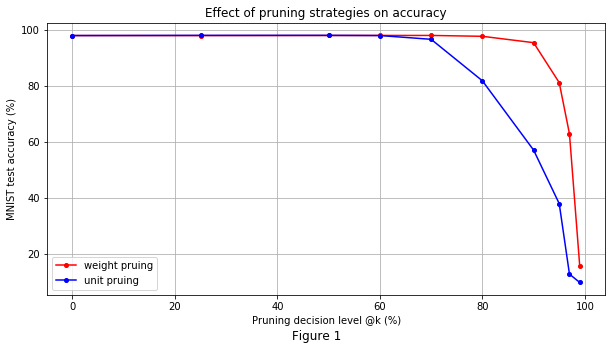

In [11]:
# Figure 1
plt.plot(pruning_levels, wp_acc, marker='.', markersize=8, color='red', label='weight pruing')
plt.plot(pruning_levels, up_acc, marker='.', markersize=8, color='blue', label='unit pruing')

plt.title('Effect of pruning strategies on accuracy')
plt.ylabel('MNIST test accuracy (%)')
plt.xlabel('Pruning decision level @k (%)')
plt.legend()
plt.grid(True)
plt.figtext(0.5, 0, "Figure 1", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

### Plot: Method sparisty vs accuracy

Each method induces an amount of sparsity into the network. Plot this total sparsity aggainst accuracy.

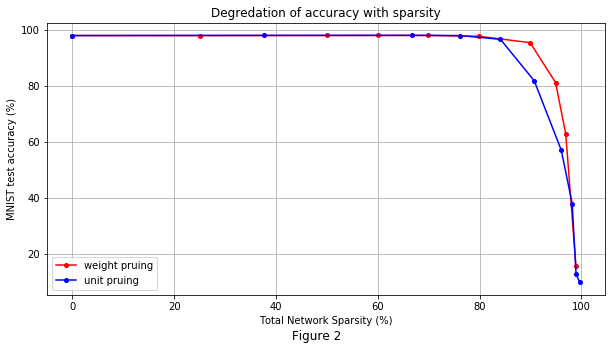

In [12]:
# Figure 2
plt.plot(wp_sparsity, wp_acc, marker='.', markersize=8, color='red', label='weight pruing')
plt.plot(up_sparsity, up_acc, marker='.', markersize=8, color='blue', label='unit pruing')

plt.title('Degredation of accuracy with sparsity')
plt.ylabel('MNIST test accuracy (%)')
plt.xlabel('Total Network Sparsity (%)')
plt.legend()
plt.figtext(0.5, 0, "Figure 2", wrap=True, horizontalalignment='center', fontsize=12)
plt.grid(True)
plt.show()

### Faster execution

Given that the above methods are effective at introducing high levels of sparsity into the network, the question becomes: can we exploit that sparsity for faster execution? By running evaluation with the SparseWeightPruned model we force inference to use SparseTensors.

In [0]:
# sanity check that both dense- and sparse-matmuls give the same results
wp_model = weight_prune(clone_model(model), 80)
densematmul_ouput = wp_model(x_train[0].reshape(1, -1))

wps_model = weight_prune_sparse(clone_model(model), 80)
sparsematmul_ouput = wps_model(x_train[0].reshape(1, -1))

np.testing.assert_array_almost_equal(
    densematmul_ouput,
    sparsematmul_ouput
)

In [14]:
pruning_levels = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

up_timing_runs = []
wp_timing_runs = []
wp_sparse_timing_runs = []

# run several times to get reliable timings
for i in tqdm.tqdm(range(10)):
  _, up_sparsity, up_timing = evaluate_pruning_method(model, pruning_levels, unit_prune)
  _, wp_sparsity, wp_timing = evaluate_pruning_method(model, pruning_levels, weight_prune)
  _, _, wp_timing_sparse = evaluate_pruning_method(model, pruning_levels, weight_prune_sparse)
  up_timing_runs.append(up_timing)
  wp_timing_runs.append(wp_timing)
  wp_sparse_timing_runs.append(wp_timing_sparse)

# collate and average run timings
wp_timing_sparse = np.stack(wp_sparse_timing_runs).mean(axis=0)
wp_timing = np.stack(wp_timing_runs).mean(axis=0)
up_timing = np.stack(up_timing_runs).mean(axis=0)

100%|██████████| 10/10 [03:13<00:00, 19.50s/it]


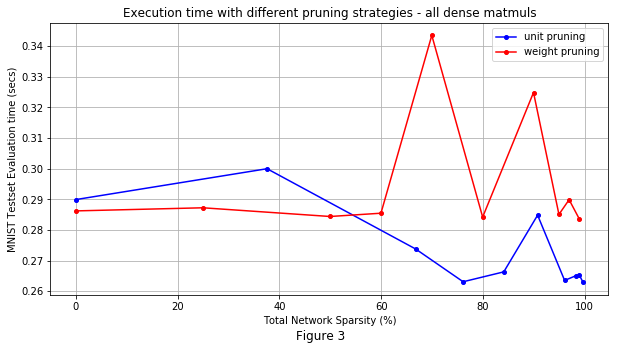

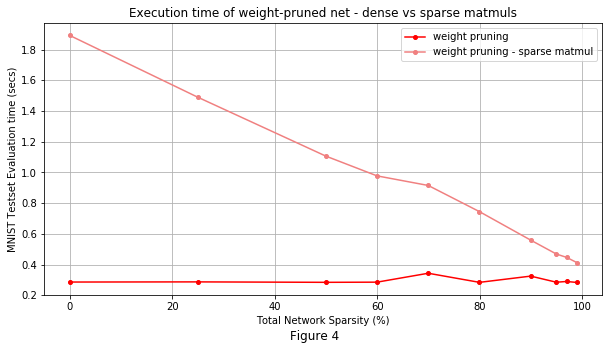

In [15]:
# Figure 3
plt.plot(up_sparsity, up_timing, marker='.', markersize=8, color='blue', label='unit pruning')
plt.plot(wp_sparsity, wp_timing, marker='.', markersize=8, color='red', label='weight pruning')
plt.title('Execution time with different pruning strategies - all dense matmuls')
plt.ylabel('MNIST Testset Evaluation time (secs)')
plt.xlabel('Total Network Sparsity (%)')
plt.figtext(0.5, 0, "Figure 3", wrap=True, horizontalalignment='center', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Figure 4
plt.plot(wp_sparsity, wp_timing, marker='.', markersize=8, color='red', label='weight pruning')
plt.plot(wp_sparsity, wp_timing_sparse, marker='.', markersize=8, color='lightcoral', label='weight pruning - sparse matmul')
plt.title('Execution time of weight-pruned net - dense vs sparse matmuls')
plt.ylabel('MNIST Testset Evaluation time (secs)')
plt.xlabel('Total Network Sparsity (%)')
plt.figtext(0.5, 0, "Figure 4", wrap=True, horizontalalignment='center', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


## Analysis

### Summary
It is evident that both pruning strategies are effective for pruning away a very significant proportion of the total network, whilst maintaining good classification accuracy. Figure 2 shows that we can obtain negligable accuracy loss whilst operating at a total network sparsity of ~82%.

Both unit and weight pruning degrade at the very high sparsity levels (falling all the way to chance-levels), however neither harm performance in the 0-80% range. Weight pruning in these experiments has an edge in the critial zone between ~90-95%. This range is critical because is represents the region where a practitioner may practically wish to trade between sparsity and accuracy.

### Why is sparsity possible?

* First, why are such high levels of sparsity possible without any accuracy degredation? Neural networks are typically highly over-parameterised. In this setup we have 60,000 training points but 2,386,000 parameters. It is concievable therefore that the majority of suitable functions in hypothesis space do not need all those paramters to constrain the function. Empirically we see that only ~20% of the parameters are really required to parameterise a good function for MNIST. This corresponds to effectively only exploiting $2,386,000 * 0.2~=477,200$ parameters to train on 60,000 data points. Interestingly, this falls within one order of magnitude of traditional wisdom of allocating 1 parameter per data point, so from a pure data vs model capacity standpoint these results aren't too surprising.

* More surprising is that the key routes that through the network implicitly follow a sparse pattern. A-priori, it could be that we depend weakly on the combination of *all* weights in the network, but we don't. Instead we depend on several key sparsely activated routes which are parameterised by large weight values. I hypothesise that the the ReLU activation amplifies this affect by encouraging routes through the network which derive from high activations and zeroing out weakly activated routes. Whatever the case, optimization **finds it very easy** to provide us with a solution which is implicitly sparse already, allowing us to remove the majority of weights with impunity.


### Why is weight pruning more effective?

Figure 2 shows unit pruning has an earlier degredation in performance - why might this be? In unit pruning we are making a much coarser decision about what to throw away; low norm columns may contain a number of high valued weights which were critical for classifying a certain proportion of inputs. In addition, such zeroing of a column triggers the zeroing of a whole row of the next layer's weight matrix which may have contained **many** (not just few) important weights. For this reason I suspect we see unit-pruning falling away sooner.

Having said that, unit-pruning produces a much "nicer" sparsity pattern which will compress on disk more effectively (whole ranges are removed rather than random weights) so there is certainly an additional tradeoff here between sparsity regularity and accuracy. In fact, the sparsity is so regular is allows us to continue to use dense matrix multiplies (but on smaller dimensions) which, as discussed further below, yields a gain in execution speed.

### How does sparisty affect execution speed?

* The unit-pruned and weight-pruned dense matrix multiplications execute efficiently (relative to the sparse-matmul version) with the unit-pruned networks making relative gains in performance above the 50% sparsity level. This is expected since the matrix multiplication dimensions become smaller under unit-pruning at higher levels of sparsity. Between sparsity levels of 90-100%, unit-pruned networks give a consistent ~6.5% relative improvement in execution speed.

* Figure 4 suggests that current GPU-based implementations of sparse matrix multiplications are unable to outperform dense generalised matrix multiplications, until we reach very high levels of sparsity. It is well known that dense matrix multiplications map very nicely onto GPU topologies whereas it is more difficult to exploit sparse patterns in a parallelised fashion. I experimented with adjusting the testset batch size but the pattern from Figure 4 held the same across `batch_size=[32,64,128,256,1024]`

My takeaway from Figure 3 and Figure 4 is that sparsity can't be exploited effectively on current hardware. Custom ASICs could potentially do better in future, but for now it seems that current generation GPUs struggle on non-square sparse matrix multiplies.


References:

https://stackoverflow.com/questions/44859321/how-to-perform-efficient-sparse-matrix-multiplication-by-using-tf-matmul

## Ideas for next steps

* Investigate interaction with quantisation; hypothesis is that magnitude is the decisive factor to sparsity which quantisation doesn't affect. Quantise first then check we can still prune and obtain the same graphs.
* Prune during training: the network can learn to exploit emerging sparse patterns during training which may result in more accurate final models but at the same sparsity level
* Hattie Zhou presented [1,2]  [Deconstructing Lottery Tickets: Zeros, Signs, and the Supermask](https://arxiv.org/abs/1905.01067) this year at ICML 2019. It explores the idea of improving the [lottery ticket alogorithm](https://arxiv.org/abs/1803.03635) as follows: instead of keeping weights with largest final magnitudes, **keep weights that increased in magnitude most during training.** It could be interesting to investigate the effect of defining Targeted Dropout's targeted proportion of weights according to *that* rule.



---


[1] https://www.facebook.com/icml.imls/videos/450413519084800/

[2] http://bit.ly/supermasks